# Product Space FEM
Finite Element Method performed on spatial domains
of the form $\Omega\times\Omega$. Uses FEniCS for 
assembly in the marginal domain $\Omega$.

In [1]:
import numpy as np
from fenics import *
import product_fem as prod

## Usage
First, create a `FunctionSpace` $V$ on a mesh of
$\Omega$ using FEniCS, as per usual. Next
define $\partial\Omega$, if desired, and create
a `ProductFunctionSpace` $W$ defined on
$\Omega\times\Omega$. By default, we use
$\partial(\Omega\times\Omega) = 
\partial\Omega\times\Omega \cup 
\Omega\times\partial\Omega$
but this can be changed with the `ProductBoundary`
object. The boundary values can be set with
`ProductDirichletBC`. 

Now we can express the associated linear system
$AU=b$
entirely in terms of integrals over $\Omega$ such
that $A=B_x\otimes C_y + C_x\otimes B_y$ and 
$b = c_x\otimes d_y$ where subscripts denote the
variable of integration. These 4 forms are assembled
and combined into $A$ and $b$ using `assemble_product`, 
then the boundary conditions are applied with `bc.apply`.
Alternatively, one may combine these last two steps
by using `assemble_product_system`.


The purpose of `ProductFunctionSpace` is to store 
the marginal function space $V$ and product
indexing information. For example, the `dofmap`
attribute is an instance of the `ProductDofMap` object, which handles various maps between dofs 
(product and marginal) and the dof coordinates 
(product and marginal).

In [2]:
n = 22
mesh = UnitIntervalMesh(n-1)
V = FunctionSpace(mesh, 'CG', 1)
W = prod.ProductFunctionSpace(V)

Now we should set the `ProductDirichletBC`.
The usage is similar to `DirichletBC` except we
instantiate it with a `ProductFunctionSpace`.
For example, say we want to use the default product
boundary and the solution should vanish on this boundary.
Then we need only write
```
bc = ProductDirichletBC(W, 0, 'on_boundary')
```
In the case we have a non-constant boundary condition
on a boundary other than the default product boundary,
we just define the boundary value function `g` that
maps $(x,y)\mapsto g(x,y)$ as well as a boundary
defining function `on_product_boundary` that maps 
$(x,y)$ to a boolean that allows us to identify the
correct subset of dofs that are on the boundary.

### Example
To demonstrate a product space solve, we'll consider

$$
\begin{align*}
    -\Delta u &= f \text{ in }\Omega\times\Omega\\
    u &= 0 \text{ on }\partial(\Omega\times\Omega)
\end{align*}
$$

We can manufacture the analytic solution to be
$u(x,y) = -x(1-x)y(1-y)\exp(x-y)$
by defining $f(x,y) = -\Delta u$.
Notice this example is a fine test case since
$u$ vanishes on the boundary
but is nontrivial inside $\Omega$.
It turns out that the explicit definition of $f$ is
$f(x,y) = 2x(y-1)(xy-2x+y+2)\exp(x-y)$,
which can be expressed as an inner product of vector-valued functions on $\Omega$, i.e.
$f(x,y) = \langle X(x), Y(y)\rangle$.

In [3]:
bc = prod.ProductDirichletBC(W, 0)

# force function sum_i X_iY_i
X = ['2 * x[0] * exp(x[0])', 
     '-4 * x[0] * x[0] * exp(x[0])',
     '2 * x[0] * x[0] * exp(x[0])', 
     '4 * x[0] * exp(x[0])']
X = [Expression(x, element=V.ufl_element()) for x in X]

Y = ['x[0] * (x[0] - 1) * exp(-x[0])', 
     '(x[0] - 1) * exp(-x[0])',
     'x[0] * (x[0] - 1) * exp(-x[0])', 
     '(x[0] - 1) * exp(-x[0])']
Y = [Expression(y, element=V.ufl_element()) for y in Y]

# assembly
u, v = TrialFunction(V), TestFunction(V)
B_form = u.dx(0) * v.dx(0) * dx
C_form = u * v * dx
A_forms = [B_form, C_form]

c_forms = [fx * v * dx for fx in X]
d_forms = [fy * v * dx for fy in Y]
b_forms = [c_forms, d_forms]

A, b = prod.assemble_product_system(A_forms, b_forms, bc)
u = np.linalg.solve(A, b)

### $L^2$ error convergence
We should expect the $L^2$ norm to decay with
increasing mesh resolution.
Theory tells us (need source) that for this family of 
elliptic PDEs, using CG1 elements with mesh resolution $h$ 
will result in 

$$
\| u - u_h \|_2 \approx Ch^2
$$

for some constant $C$. Here we take $h$ to be the 
maximum edge length of the mesh.
For example, a mesh on $[0,1]$ with $n$ evenly spaced
nodes will have $h=\frac{1}{n-1}$.
To sanity check this we'll compute $\|u - u_h\|_2$ 
for increasing values of $n$, fit a linear model
to $\log(\|u - u_h\|_2) \sim \log(h)$, 
and confirm the slope is 2.

In [4]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def mesh_res_error(n):
    mesh = UnitIntervalMesh(n-1)
    h = mesh.hmax()
    V = FunctionSpace(mesh, 'CG', 1)
    W = prod.ProductFunctionSpace(V)

    bc = prod.ProductDirichletBC(W, 0)

    # force function sum_i X_iY_i
    X = ['2 * x[0] * exp(x[0])', 
         '-4 * x[0] * x[0] * exp(x[0])',
         '2 * x[0] * x[0] * exp(x[0])', 
         '4 * x[0] * exp(x[0])']
    X = [Expression(x, element=V.ufl_element()) for x in X]

    Y = ['x[0] * (x[0] - 1) * exp(-x[0])', 
         '(x[0] - 1) * exp(-x[0])',
         'x[0] * (x[0] - 1) * exp(-x[0])', 
         '(x[0] - 1) * exp(-x[0])']
    Y = [Expression(y, element=V.ufl_element()) for y in Y]

    # assembly
    u, v = TrialFunction(V), TestFunction(V)
    B_form = u.dx(0) * v.dx(0) * dx
    C_form = u * v * dx
    A_forms = [B_form, C_form]

    c_forms = [fx * v * dx for fx in X]
    d_forms = [fy * v * dx for fy in Y]
    b_forms = [c_forms, d_forms]

    A, b = prod.assemble_product_system(A_forms, b_forms, bc)
    u = np.linalg.solve(A, b)

    # can compute integrals using mass matrix M_ij = int phi_i dx * int phi_j dy
    # then int f(x,y) dxdy = sum_ij int f_ij phi_i(x) phi_j(y) dxdy
    #                      = sum_ij f_ij M_ij
    mass = assemble(v * dx)[:]
    mass = np.kron(mass, mass)

    # convergence checking
    # errornorm(u, u_anal) = int (u-u_anal)^2 dx
    dof_to_coords = W.dofmap._dofs_to_coords
    u_anal = np.zeros_like(u)
    analytic_u = lambda x,y: x * (x - 1) * y * (1 - y) * np.exp(x - y)
    for dof, xy in dof_to_coords.items():
        u_anal[dof] = analytic_u(xy[0], xy[1])
    l2_error = np.dot((u - u_anal)**2, mass)

    return h, np.sqrt(l2_error)

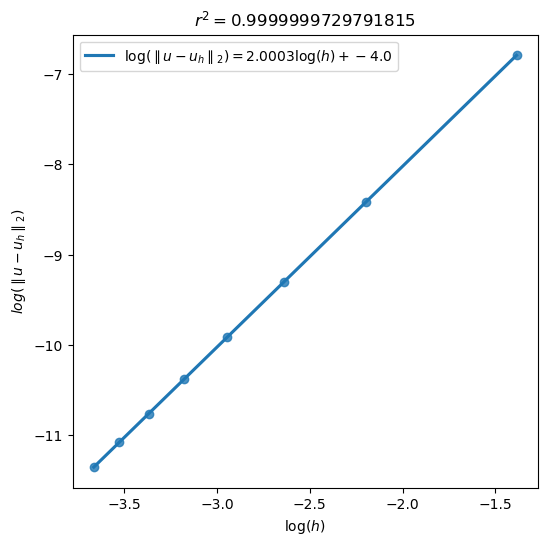

In [5]:
# organize data frame
ns = [5, 10, 15, 20, 25, 30, 35, 40]
h_errors = np.array([mesh_res_error(n) for n in ns])
hs, l2_err = h_errors[:,0], h_errors[:,1]
data = {'n': ns, 'h': hs, 'log_h': np.log(hs), 'l2_err': l2_err, 'log_l2_err': np.log(l2_err)}
data = pd.DataFrame(data)

# perform regression and plot
slope, intercept, r, p, se = stats.linregress(data['log_h'], data['log_l2_err'])
line_kws={'label':fr'$\log(\parallel u - u_h\parallel_2) = {np.round(slope, 4)} \log(h) + {np.round(intercept, 1)}$'}
ax = sns.regplot(x='log_h', y='log_l2_err', data=data, 
                 ci=None, order=1, line_kws=line_kws)
# aesthetics
ax.figure.set_dpi(100)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(6)
ax.set_xlabel(r'$\log(h)$')
ax.set_ylabel(r"$ log(\parallel u - u_h\parallel_2)$")
ax.set_title(fr'$r^2 = {r**2}$')
ax.legend()
plt.show()

Evidently $\|u - u_h\|_2 \approx \mathcal{O}(h^2)$, as claimed.